# Рекомендация тарифов

Заказчик хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра». В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

**_Цель исследования:_**

>Подготовить модель машинного обучения для подбора опитимального тарифа пользователям.

**_Описание данных:_**

Представленный датасет включает следующие колонки:

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).
 
**_План работ:_**

- Изучение предоставленного датасета 
- Разбивка датасета на тестовую и валидационную выборку 
- Подготовка моделей машинного обучения
- Тестирование созданных моделей


In [2]:
#Импортируем бибилотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score


## Подготовка датасета

In [3]:
#Открываем файл с датасетом
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')

In [4]:
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


In [8]:
#нашел такой вариант на stackoverflow для решения вопроса о сбалансированности выборки
balance = df['is_ultra'].value_counts(normalize=True).reset_index()
print(balance)

#Тариф ультра встречается только в 30% случаях, а значит выборка не сбалансирована.

   index  is_ultra
0      0  0.693528
1      1  0.306472


**Вывод:** В датасете 3214 строчки. Все этапы предобработки данных были выполненны заранее, поэтому в дополнительной предобработке датасет не нуждается. Медианные значения у всех пользователей в датасете: звонки - 62, минуты - 430.6 , смс - 30, использовано мегабайт - 16943.23. При изучении корреляции параметров датасета была вявленя полная корреляция столбцов calls и minutes. Для обучения модели желательно избавиться от одного из указанных столбцов т.к. эти признаки дублируют друг друга.

## Разбивка данных на выборки

In [9]:
#Извлечение признаков и целевого признака для обучения модели
features = df.drop('is_ultra', axis = 1)
target = df['is_ultra']

In [10]:
#Деление датасета на выборки
features_train, X_rem, target_train, y_rem = train_test_split(
    features, target, train_size=0.60, shuffle = False)

features_valid, features_test, target_valid, target_test = train_test_split(
    X_rem, y_rem, test_size=0.50)

In [11]:
print(features_train.shape, features_valid.shape, features_test.shape)

(1928, 4) (643, 4) (643, 4)


In [12]:
#Проверка сбалансированности выборки
balance = target_train.value_counts(normalize=True)
print(balance)

0    0.686722
1    0.313278
Name: is_ultra, dtype: float64


In [13]:
#Проверка сбалансированности выборки
balance = target_valid.value_counts(normalize=True)
print(balance)

0    0.720062
1    0.279938
Name: is_ultra, dtype: float64


In [14]:
#Проверка сбалансированности выборки
balance = target_test.value_counts(normalize=True)
print(balance)

0    0.687403
1    0.312597
Name: is_ultra, dtype: float64


**Вывод:** Датасет был разделен на 3 части (обучающая, валидационная и тестовая выборки).

## Исследование моделей

In [15]:
%%time
#Модель дерева решений

#обнуление счетчиков
best_model_tree = None
best_result_tree = 0

result_train_tree = []
result_valid_tree = []

#Цикл для поиска лучшей модели
for depth in range(1, 11):
    
    model = DecisionTreeClassifier(max_depth=depth, random_state = 12345)
    
    model.fit(features_train, target_train) #Обучение
    
    #обучающая выборка
    predictions_tree_train = model.predict(features_train) #Предсказание
    result_train = accuracy_score(target_train, predictions_tree_train)   #Оценка предсказания
    result_train_tree.append(result_train) #запись результата
    
    #валидационная выборка
    predictions_tree_valid = model.predict(features_valid) #Предсказание
    result_valid = accuracy_score(target_valid, predictions_tree_valid)   #Оценка предсказания
    result_valid_tree.append(result_valid) #запись результата
    
    #Сохранение параметров лучшей модели 
    if result_valid > best_result_tree:
        
        best_model_tree = model
        best_depth_tree = depth
        best_result_tree = result_valid
        

CPU times: user 88.1 ms, sys: 452 µs, total: 88.6 ms
Wall time: 96.5 ms


In [16]:
print('Наилучший рузультат модели дерева решений:', best_result_tree)
print('Кол-во деревьев в лучшей модели:', best_depth_tree)
print(best_model_tree)

Наилучший рузультат модели дерева решений: 0.8164852255054432
Кол-во деревьев в лучшей модели: 6
DecisionTreeClassifier(max_depth=6, random_state=12345)


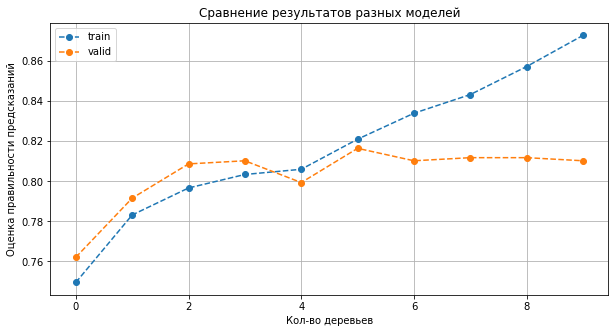

In [17]:
#визуальный поиск лучшей модели

plt.figure(figsize =(10,5))

plt.plot(result_train_tree, marker='o', linestyle='dashed')
plt.plot(result_valid_tree, marker='o', linestyle='dashed')

plt.grid(True)

plt.xlabel('Кол-во деревьев')
plt.ylabel('Оценка правильности предсказаний')
plt.title('Сравнение результатов разных моделей')

plt.legend(['train', 'valid'])

plt.show()

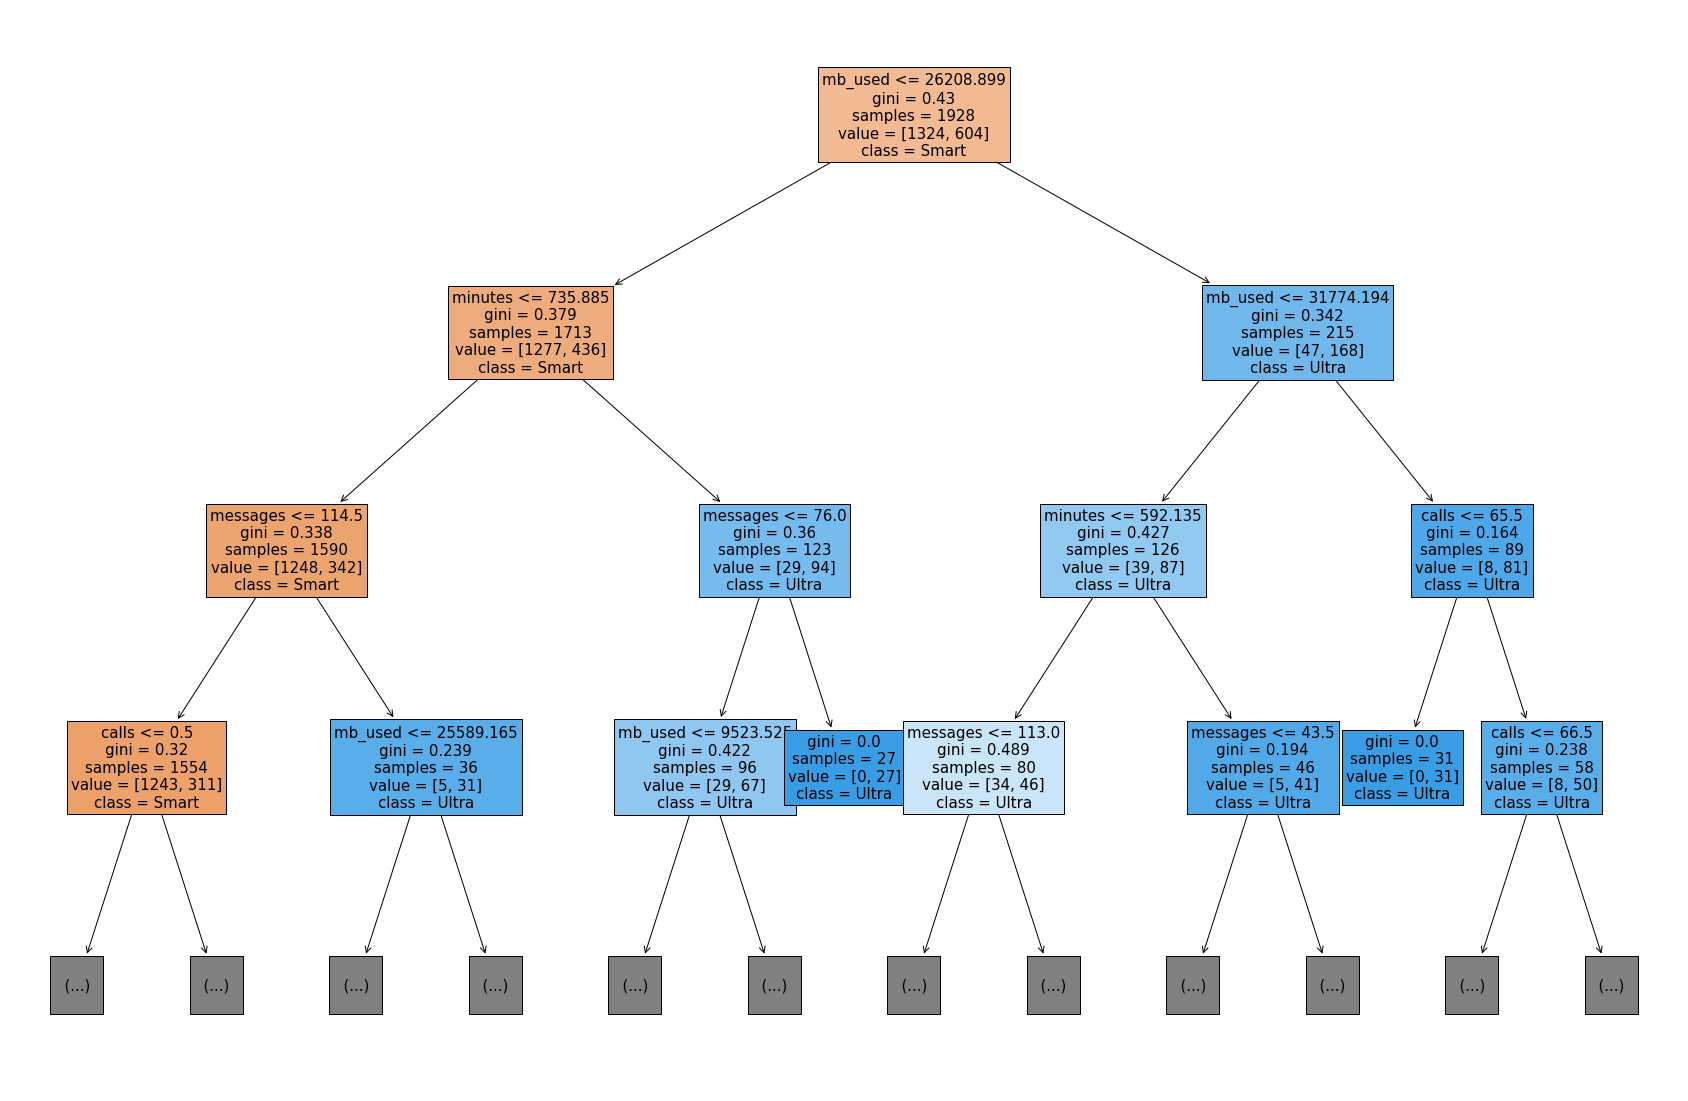

In [18]:
#Просмотр логики решений лучшей модели 

fig = plt.figure(figsize=(30,20))
tree.plot_tree(best_model_tree, class_names=['Smart','Ultra'],
               feature_names = ['calls', 'minutes', 'messages', 'mb_used'],
               label = 'all',
               proportion=False,
               fontsize = 15, max_depth = 3,
               filled = True)
plt.show()

In [19]:
%%time
#случайный лес

#обнуление счетчиков
best_model_rforest = None
best_result_rforest = 0

result_train_rforest = []
result_valid_rforest = []

#Цикл для поиска лучшей модели
for est in range(10, 51, 10):
    for depth in range (1, 11):
        
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        
        model.fit(features_train, target_train) #Обучение
        
        #обучающая выборка
        predictions_rforest_train = model.predict(features_train) #Предсказание
        result_train = accuracy_score(target_train, predictions_rforest_train) #Оценка предсказания
        result_train_rforest.append(result_train) #запись результата
        
        #валидационная выборка
        predictions_rforest_valid = model.predict(features_valid) #Предсказание
        result_valid = accuracy_score(target_valid, predictions_rforest_valid) #Оценка предсказания
        result_valid_rforest.append(result_valid) #запись результата
        
        
        #Сохранение параметров лучшей модели 
        if result_valid > best_result_rforest:
            
            best_model_rforest = model 
            best_result_rforest = result_valid
            best_est_rforest = est
            best_depth_rforest = depth

            

CPU times: user 3.71 s, sys: 30.2 ms, total: 3.74 s
Wall time: 3.74 s


In [20]:
print('Наилучший рузультат модели "случайный лес":', best_result_rforest)
print('Количество деревьев в модели:', best_est_rforest)
print('Количество листьев в модели:', best_depth_rforest)

Наилучший рузультат модели "случайный лес": 0.8320373250388803
Количество деревьев в модели: 10
Количество листьев в модели: 9


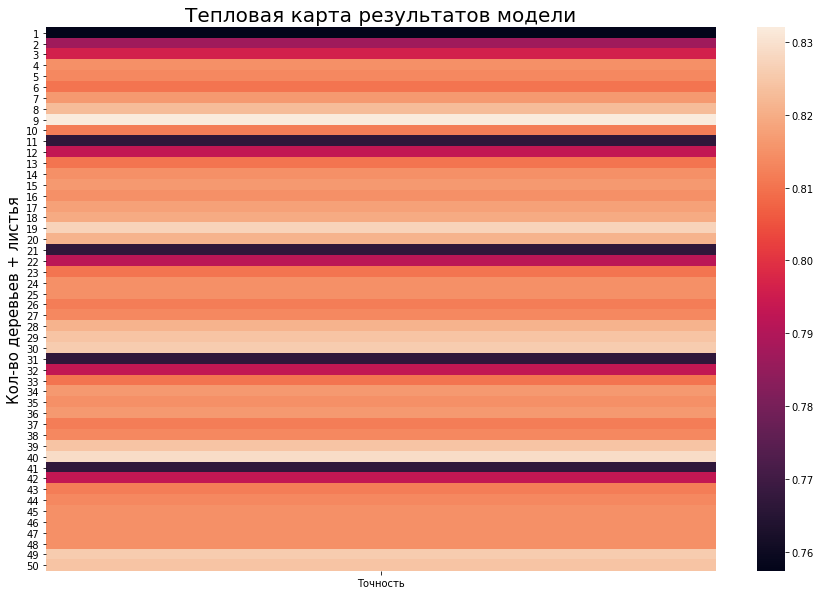

In [25]:
#визуальный поиск лучшей модели

result_valid_rforest = pd.DataFrame(data = result_valid_rforest, columns=['Точность'], index = range(1,51))

plt.figure(figsize =(15,10))

sns.heatmap(result_valid_rforest) #тепловая карта
plt.title('Тепловая карта результатов модели', fontsize = 20) 
plt.ylabel('Кол-во деревьев + листья', fontsize = 15) 

plt.show()

In [22]:
%%time
#Логическая регрессия

#обнуление счетчиков
best_model_logic = None
best_result_logic = 0

result_train_logic = []
result_valid_logic = []

#Цикл для поиска лучшей модели
for iters in range (100, 2000, 100):
        
    model = LogisticRegression(random_state = 12345, solver='lbfgs', max_iter = iters)
        
    model.fit(features_train, target_train) #Обучение 
    
    predictions_logic_train = model.predict(features_train) #Предсказание 
    result_train = accuracy_score(target_train, predictions_logic_train) #Оценка предсказания
    result_train_logic.append(result_train) #запись результата
    

    predictions_logic_valid = model.predict(features_valid) #Предсказание 
    result_valid = accuracy_score(target_valid, predictions_logic_valid) #Оценка предсказания
    result_valid_logic.append(result_valid) #запись результата
        
    #Сохранение параметров лучшей модели 
    if result_valid > best_result_logic:
            
        best_model_logic = model 
        best_result_logic = result_valid
        best_iter_logic = iters 
            


CPU times: user 716 ms, sys: 8.3 ms, total: 724 ms
Wall time: 743 ms


In [23]:
print('Наилучший рузультат модели "логическая регрессия":', best_result_logic)
print('Количество итераций в лучшем рузльтате:', best_iter_logic)

Наилучший рузультат модели "логическая регрессия": 0.7293934681181959
Количество итераций в лучшем рузльтате: 100


**Вывод:** Наилучший результат на валидационной выборке показала модель "случайный лес" - 0.817, но для этого ей потребовалось создать 20 деревьев. Самое низкий результат, относительно остальных моделей, у логической регресии - 0.705, но лучший результат модели достигается всего при 100 итерациях. "Дерево решений" - лучший результат модели 0.80 при создании 4 деревьев.

## Проверка модели на тестовой выборке

In [24]:
%%time
#Случайный лес

predictions_rforest_test = best_model_rforest.predict(features_test)
result = accuracy_score(target_test, predictions_rforest_test)   

print('Доля правильных ответов на тренировочной выборке (случайный лес):', result)

Доля правильных ответов на тренировочной выборке (случайный лес): 0.8258164852255054
CPU times: user 7.33 ms, sys: 0 ns, total: 7.33 ms
Wall time: 6.9 ms


In [25]:
#объеденение тренировочной и валидационной выборок
features_con = pd.concat((features_train, features_valid), axis = 0)
target_con = pd.concat((target_train, target_valid),axis =  0)

In [26]:
#проверка корректности после объеденения
print(features_con.head(), f'\n\n', target_con.head())

   calls  minutes  messages   mb_used
0   40.0   311.90      83.0  19915.42
1   85.0   516.75      56.0  22696.96
2   77.0   467.66      86.0  21060.45
3  106.0   745.53      81.0   8437.39
4   66.0   418.74       1.0  14502.75 

 0    0
1    0
2    0
3    1
4    0
Name: is_ultra, dtype: int64


In [27]:
#проверка предсказания модели на тестовой выборке после обучения на объедененной
test_RF = RandomForestClassifier(random_state=12345, n_estimators=best_est_rforest, max_depth=best_depth_rforest)
test_RF.fit(features_con, target_con)

predict = test_RF.predict(features_test) #предсказание
result = accuracy_score(target_test, predict)#результат


In [28]:
print('Результат модели натренированной на объедененной выборке:', result)

Результат модели натренированной на объедененной выборке: 0.8351477449455676


**Вывод:** После обучения модели на объедененной выборке результат немного ухудшился.

## Проверка модели на адекватность

In [29]:
balance = target_test.value_counts(normalize=True)
print(balance)

0    0.710731
1    0.289269
Name: is_ultra, dtype: float64


In [30]:
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(features_test, target_test)

dummy_clf.predict(features_test)

dummy_clf.score(features_test, target_test)

0.7107309486780715

<div style="border:solid steelgreen 4px; padding: 20px; border-radius: 15px">
<h1>Итог:</h1>

>В ходе работы были выполнены следующие операции:
>>- Изучена общая информация о представленном датасете
>>- Подготовленны обучающие и тренировочные выборки для обучения моделей
>>- Исследованы результаты работы различных моделей
>>- Проведено тестирование моделей на валидационной выборке
>>- Проверены показатели метрики моделей
   

> В ходе исследования была выявлена самая лучшая модель для определения наилучшего тарифа для пользователей - "Случайный лес". У данной модели самый лучший показатель accuracy - 0.83. Данный моказатель был достигнуть при построении 30 деревьев по 4 ответвления в каждом.

>Модель, ближе всего подходящая при оценке на адекватность - "Логическая регрессия".